# Roger Federer Match Length History Pilot Analysis

Now this is exciting ! We will now go beyond analysing generalized (ie. non player specific) match length data and take a look at a specific player : the GOAT Roger Federer. There are several reasons for this choice (many matches at the top level, long career spanning more than two decades, evolution in terms of playstyle) but mainly Federer is my tennis hero.

The goal here is to obtain a series of weighted variables which would allow us to predict the length of a Roger Federer match against a given opponent, under a given set of match conditions. For this, let's implement a decision tree model.

In [21]:
### IMPORTS ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
### CLEAN FEDERER MATCHES TABLES ###

setup = False

if (setup) :

    atp = pd.read_csv("atp_cat.csv")

    fed_won = atp[atp["winner_name"] == "Roger Federer"]    # 1163 wins
    fed_lost = atp[atp["loser_name"] == "Roger Federer"]    # 261 loses (82% winrate) (1424 matches total)

    # We'll drop all of Federer's information except his age
    fed_won = fed_won.drop(labels=["winner_name", "winner_hand", "winner_ht", "winner_ioc"], axis=1)
    fed_won = fed_won.rename(columns={"winner_age": "fed_age", "winner_rank": "fed_rank", "winner_rank_points": "fed_rank_points",
                                    "loser_name":"opp_name", "loser_hand":"opp_hand", "loser_ht":"opp_ht", "loser_ioc":"opp_ioc", "loser_age":"opp_age",
                                    "loser_rank": "opp_rank", "loser_rank_points": "opp_rank_points"})
    fed_won["index2"] = fed_won.index
    fed_won["fed_won"] = "1"

    fed_lost = fed_lost.drop(labels=["loser_name", "loser_hand", "loser_ht", "loser_ioc"], axis=1)
    fed_lost = fed_lost.rename(columns={"loser_age": "fed_age", "loser_rank": "fed_rank", "loser_rank_points": "fed_rank_points",
                                        "winner_name":"opp_name", "winner_hand":"opp_hand", "winner_ht":"opp_ht", "winner_ioc":"opp_ioc", "winner_age":"opp_age",
                                        "winner_rank": "opp_rank", "winner_rank_points": "opp_rank_points"})
    fed_lost["index2"] = fed_lost.index
    fed_lost["fed_won"] = "0"

    fed = pd.concat([fed_won, fed_lost])
    fed = fed.drop(["Unnamed: 0", "index2"] , axis=1)
    fed.sort_index(inplace=True)

    fed.to_csv("fed.csv")     # Saving the table for ease of use

else :

    fed = pd.read_csv("fed.csv")

fed    # Clean Table of all Roger Federer ATP matches

,Unnamed: 0,tourney_name,surface,tourney_level,tourney_date,fed_age,opp_name,opp_hand,opp_ht,opp_ioc,...,score,best_of,round,minutes,fed_rank,fed_rank_points,opp_rank,opp_rank_points,fed_won,consecutive
0,24174,Gstaad,Clay,A,19980706,16.908966,Lucas Arnold Ker,R,180.0,ARG,...,6-4 6-4,3,R32,80.0,702.0,19.0,88.0,601.0,0,0
1,24932,Toulouse,Hard,A,19980928,17.138946,Guillaume Raoux,R,180.0,FRA,...,6-2 6-2,3,R32,60.0,878.0,9.0,45.0,859.0,1,0
2,24941,Toulouse,Hard,A,19980928,17.138946,Richard Fromberg,R,196.0,AUS,...,6-1 7-6(5),3,R16,85.0,878.0,9.0,43.0,927.0,1,1
3,24946,Toulouse,Hard,A,19980928,17.138946,Jan Siemerink,L,183.0,NED,...,7-6(5) 6-2,3,QF,79.0,878.0,9.0,20.0,1652.0,0,0
4,24954,Basel,Hard,A,19981005,17.158111,Andre Agassi,R,180.0,USA,...,6-3 6-2,3,R32,60.0,396.0,77.0,8.0,2545.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,85607,Wimbledon,Grass,G,20210628,39.887748,Adrian Mannarino,L,183.0,FRA,...,6-4 6-7(3) 3-6 6-2 0-0 RET,5,R128,164.0,8.0,4815.0,41.0,1571.0,1,1
1420,85646,Wimbledon,Grass,G,20210628,39.887748,Richard Gasquet,R,185.0,FRA,...,7-6(1) 6-1 6-4,5,R64,111.0,8.0,4815.0,56.0,1148.0,1,2
1421,85666,Wimbledon,Grass,G,20210628,39.887748,Cameron Norrie,L,188.0,GBR,...,6-4 6-4 5-7 6-4,5,R32,155.0,8.0,4815.0,34.0,1770.0,1,3
1422,85676,Wimbledon,Grass,G,20210628,39.887748,Lorenzo Sonego,R,191.0,ITA,...,7-5 6-4 6-2,5,R16,131.0,8.0,4815.0,27.0,2038.0,1,4


## Simple Regression Decision Tree

We will create a simple decision tree using five features :
- Surface  
- Best of  
- Opponent hand  
- Opponent height  
- Ranking difference  

### Exploration & Visualization

In [23]:
# ATP Colors
# Dark blue : #002865
# Light blue : #00AFF0

In [24]:
# Exemple

fed_surface = pd.pivot_table(fed, values="minutes", index = ["best_of", "opp_hand"], columns=["surface"]) # average duration per surface
fed_surface

surface             Carpet        Clay       Grass        Hard
best_of opp_hand                                              
3       L          61.4000   95.363636   72.900000   82.361111
        R          93.1875   88.393750   89.388235   89.526678
5       L              NaN  161.625000  131.315789  131.050000
        R         170.7500  134.097561  124.031579  130.214634

C:\Users\uporito\Anaconda3\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\uporito\Anaconda3\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


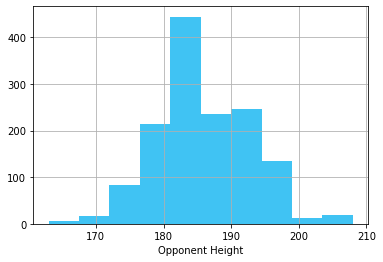

In [25]:
n, bins, patches = plt.hist(fed["opp_ht"], 10, density=False, facecolor='#00AFF0', alpha=0.75)
plt.xlabel('Opponent Height')
plt.ylabel('')
plt.grid(True)
plt.show()

### Formatting

In [47]:
fed1 = fed[["minutes", "surface", "best_of", "opp_hand", "opp_ht", "consecutive"]]
fed1["rank_diff"] = fed["fed_rank"] - fed["opp_rank"]

# One-Hot Encoding
fed1 = pd.get_dummies(data=fed1, columns=["surface", "best_of", "opp_hand"])

fed1 = fed1.dropna(axis=0, how='any')

fed1.head(5)

C:\Users\uporito\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,minutes,opp_ht,consecutive,rank_diff,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,opp_hand_R
0,80.0,180.0,0,614.0,0,1,0,0,1,0,0,1
1,60.0,180.0,0,833.0,0,0,0,1,1,0,0,1
2,85.0,196.0,1,835.0,0,0,0,1,1,0,0,1
3,79.0,183.0,0,858.0,0,0,0,1,1,0,1,0
4,60.0,180.0,0,388.0,0,0,0,1,1,0,0,1


### Regression Decision Tree



#### Pre-processing

For pre-processing we have three options :
- not scaling x or y
- scaling both x and y
- scaling x but not y   
  
I feel like scaling gives us better results but adds a hurdle in interpreting the tree's visualization since it displays scaled values. We can scale both input and output values back, just not display them with sklearns's plot_tree (or any tree visualization that I've found so far). For now, the roundabout solution is just to print out the scaled input and output.

In [48]:
### PRE-PROCESSING ###

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target='minutes'

scale_x = True
scale_y = False

def preprocessing(scale_x=False, scale_y=False) :

    # 1. X, y unscaled
    X = fed1.drop([target], axis=1)
    y = np.asarray(fed1[target])
    y = y.reshape(-1,1)

    xscaler = StandardScaler()
    yscaler = StandardScaler()

    if (scale_x) :
        print("Scaling X...")
        xscaler.fit(X[['opp_ht','rank_diff']])
        X[['opp_ht','rank_diff']] = xscaler.transform(X[['opp_ht','rank_diff']])

    if (scale_y) :
        print("Scaling y...")
        yscaler.fit(y)
        y = yscaler.transform(y)

    display(pd.DataFrame(X).head())
    display(pd.DataFrame(y).head())

    return X, y, xscaler, yscaler

X, y, xscaler, yscaler = preprocessing(scale_x, scale_y)

Scaling X...


,opp_ht,consecutive,rank_diff,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,opp_hand_R
0,-0.893796,0,7.695982,0,1,0,0,1,0,0,1
1,-0.893796,0,10.281855,0,0,0,1,1,0,0,1
2,1.433962,1,10.305471,0,0,0,1,1,0,0,1
3,-0.457342,0,10.577047,0,0,0,1,1,0,1,0
4,-0.893796,0,5.027454,0,0,0,1,1,0,0,1


,0
0,80.0
1,60.0
2,85.0
3,79.0
4,60.0


#### Building the tree

To build a good tree, we need to select values for the tree's parameters (e.g. max depth, minimum samples per leaf). We'll perform this "Hyperparameter Tuning" using GridSearchCV, a library which selects the best tree by trying every combination of parameters we give it and performing a cross validation. The trees are commpared based on the R² criteria.  
  
![score formula](res/score.png "sklearn score")  
  
After building this somewhat optimal tree, we test it on a train-test-split sample and visualize the results.

Fitting 10 folds for each of 693 candidates, totalling 6930 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 6930 out of 6930 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best paramters: {'max_depth': 4, 'min_samples_leaf': 64})
Training score 1 :  0.360956275418011
Testing score 1 :  0.2920672895594276
Fitting 10 folds for each of 693 candidates, totalling 6930 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 6930 out of 6930 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best paramters: {'max_depth': 5, 'min_samples_leaf': 39})
Training score 2 :  0.38092696333241505
Testing score 2 :  0.29405882529899807
Fitting 10 folds for each of 693 candidates, totalling 6930 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 6930 out of 6930 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best paramters: {'max_depth': 4, 'min_samples_leaf': 20})
Training score 3 :  0.39948687018125817
Testing score 3 :  0.2577485490641427
Fitting 10 folds for each of 693 candidates, totalling 6930 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 6930 out of 6930 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best paramters: {'max_depth': 4, 'min_samples_leaf': 9})
Training score 4 :  0.39403480674861335
Testing score 4 :  0.3538570136692477
Fitting 10 folds for each of 693 candidates, totalling 6930 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1392 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 5392 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 6930 out of 6930 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best paramters: {'max_depth': 3, 'min_samples_leaf': 59})
Training score 5 :  0.3394110033054607
Testing score 5 :  0.31406436605708865
Fitting 10 folds for each of 693 candidates, totalling 6930 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1872 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 5872 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 6930 out of 6930 | elapsed:   15.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best paramters: {'max_depth': 5, 'min_samples_leaf': 62})
Training score 6 :  0.37037493072150174
Testing score 6 :  0.25257709514702786
Fitting 10 folds for each of 693 candidates, totalling 6930 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 6930 out of 6930 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best paramters: {'max_depth': 5, 'min_samples_leaf': 21})
Training score 7 :  0.3828366893169347
Testing score 7 :  0.32502880529354694
Fitting 10 folds for each of 693 candidates, totalling 6930 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 6930 out of 6930 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best paramters: {'max_depth': 3, 'min_samples_leaf': 59})
Training score 8 :  0.3275556140162663
Testing score 8 :  0.3459571140183616
Fitting 10 folds for each of 693 candidates, totalling 6930 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 6930 out of 6930 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best paramters: {'max_depth': 4, 'min_samples_leaf': 28})
Training score 9 :  0.37366068185917145
Testing score 9 :  0.3392200650392576
Fitting 10 folds for each of 693 candidates, totalling 6930 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 6930 out of 6930 | elapsed:   12.6s finished


Best paramters: {'max_depth': 4, 'min_samples_leaf': 29})
Training score 10 :  0.3544815340806021
Testing score 10 :  0.38045632914375027
Test scores :  [0.2920672895594276, 0.29405882529899807, 0.2577485490641427, 0.3538570136692477, 0.31406436605708865, 0.25257709514702786, 0.32502880529354694, 0.3459571140183616, 0.3392200650392576, 0.38045632914375027]
Test scores average :  0.3155035452290849


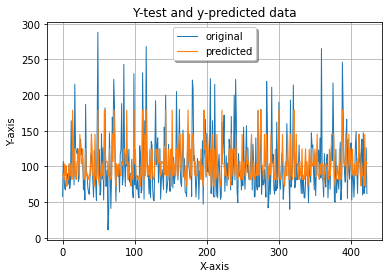

[Text(837.0, 733.86, 'best_of_3 <= 0.5\nmse = 1535.391\nsamples = 984\nvalue = 101.588'),
 Text(494.5909090909091, 570.78, 'rank_diff <= 0.369\nmse = 1961.658\nsamples = 288\nvalue = 130.462'),
 Text(304.3636363636364, 407.70000000000005, 'rank_diff <= -0.079\nmse = 1423.769\nsamples = 213\nvalue = 120.606'),
 Text(152.1818181818182, 244.62, 'surface_Clay <= 0.5\nmse = 1162.088\nsamples = 117\nvalue = 111.41'),
 Text(76.0909090909091, 81.54000000000008, 'mse = 914.786\nsamples = 87\nvalue = 106.828'),
 Text(228.27272727272728, 81.54000000000008, 'mse = 1641.743\nsamples = 30\nvalue = 124.7'),
 Text(456.54545454545456, 244.62, 'consecutive <= 2.5\nmse = 1514.048\nsamples = 96\nvalue = 131.812'),
 Text(380.4545454545455, 81.54000000000008, 'mse = 2350.462\nsamples = 35\nvalue = 145.229'),
 Text(532.6363636363636, 81.54000000000008, 'mse = 871.61\nsamples = 61\nvalue = 124.115'),
 Text(684.8181818181819, 407.70000000000005, 'consecutive <= 1.5\nmse = 2429.848\nsamples = 75\nvalue = 158.45

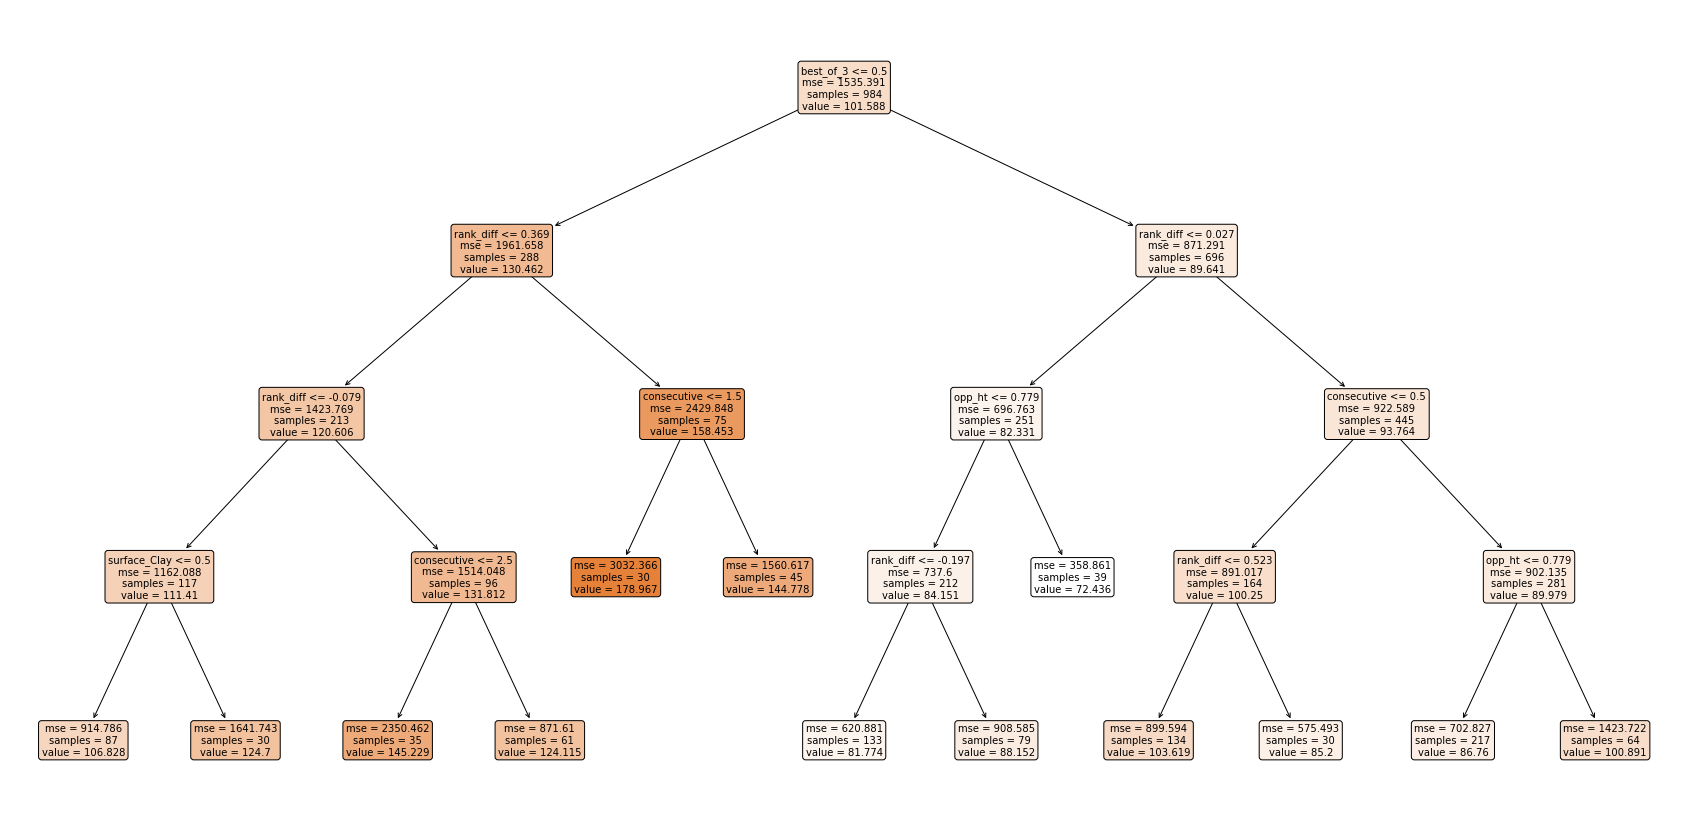

In [52]:
# Parameter Selection :

from sklearn.model_selection import GridSearchCV

params = {
    # "criterion":("squared_error", "friedman_mse", "absolute_error", "poisson"), 
    "max_depth":np.arange(3, 10), 
    "min_samples_leaf":np.arange(1, 100), 
    # "min_weight_fraction_leaf":[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.075, 0.001], 
    # "max_features":np.arange(1, 5)
}

dtr = DecisionTreeRegressor(random_state=42)
dtr_cv = GridSearchCV(dtr, params, scoring="r2", n_jobs=-1, verbose=1, cv=10)

# Fit-Train-Test Loop :

test_scores = []

for i in range(10) :

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.3)
    dtr_cv.fit(Xtrain, ytrain)

    best_params = dtr_cv.best_params_
    print(f"Best paramters: {best_params})")

    dtr = DecisionTreeRegressor(**best_params)
    dtr.fit(Xtrain, ytrain)

    # Testing :

    ypred = dtr.predict(Xtest)

    print(f"Training score {i+1} : ", dtr.score(Xtrain, ytrain))
    print(f"Testing score {i+1} : ", dtr.score(Xtest, ytest))
    test_scores.append(dtr.score(Xtest, ytest))

print("Test scores : ", test_scores)
print("Test scores average : ", sum(test_scores)/len(test_scores))

# Visualization (last tree) :

x_ax = range(len(ytest))
plt.plot(x_ax, ytest, linewidth=1, label="original")
plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
plt.title("Y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

plt.figure(figsize=(30,15))
tree.plot_tree(dtr,
          filled=True,
          rounded=True,
          fontsize=10,
          feature_names=["opp_ht", "consecutive", "rank_diff", "surface_Carpet", "surface_Clay", "surface_Grass", "surface_Hard", "best_of_3", "best_of_5", "opp_hand_L", "opp_hand_R"])

# plt.savefig('tree_high_dpi', dpi=600)

Now let's try to predict the length of a match with custom input :  
To make interpreting the tree above possible, in case of scaling, we will print out the input and/or output after scaling.

In [29]:
### CUSTOM PREDICTION ###

def predict(scale_x, scale_y, height, rank_diff, surface, best_of, hand) :
    # surface : carpet(1), clay(2), grass(3), hard(4)
    # best of : 3(1), 5(2)
    # hand : left(1), right(2)

    surface_input = [0, 0, 0, 0]
    surface_input[surface - 1] = 1

    bo_input = [0, 0]
    bo_input[best_of - 1] = 1

    hand_input = [0, 0]
    hand_input[hand - 1] = 1

    if (not scale_x and not scale_y) :  # 1. X, y unscaled
        input = [height, rank_diff] + surface_input + bo_input + hand_input
        print("Input : ", input)
        input = [input]

        print("Prediction : ", dtr.predict(input), " minutes")

    # input = [180, 0, 0, 1, 0, 0, 0, 1]

    elif (scale_x and scale_y) :    # 2. X, y scaled
        input = xscaler.transform([[height, rank_diff]])
        input = np.append(input[0], surface_input + bo_input + hand_input)
        print("Scaled input : ", input)

        input = [input]

        print("Scaled Prediction : ", dtr.predict(input), " minutes")
        print("Prediction : ", yscaler.inverse_transform(dtr.predict(input)), " minutes")

    elif (scale_x and not scale_y) :    # 3. X scaled, y unscaled
        input = xscaler.transform([[180, 0]])
        input = np.append(input[0], surface_input + bo_input + hand_input)
        print("Scaled input : ", input)
        input = [input]

        print("Prediction : ", dtr.predict(input), " minutes")

    return(dtr.predict(input))

prediction = predict(scale_x, scale_y, 180, 100, 4, 2, 2)

Scaled input :  [-0.89379627  0.44608889  0.          0.          0.          1.
  0.          1.          0.          1.        ]
Prediction :  [157.81034483]  minutes


#### Interpretation

There are a few observations to be made.  
On the subject of the tree's structure, the best trees are quite shallow (3-5 levels). This avoids overfitting.  
Next, the best-of 3 or 5 distinction is the most important feature, by far. The split along this feature is always the root split, and this should come at no surprise.
However, the surface distinction, surprisingly, doesn't seem that important. The level 2 splits almost always relate to the rank_diff feature, as do most of the subsequent splits. Usually a few random splits on surface, hand or height will show up in the last level.

### Conclusion

Here are the best scores for the 3 different pre-processing options :

x,y scaled : 0.303812186321178  
x,y unscaled : 0.2507916729068349  
x scaled, y unscaled : 0.2850867013263392  

These scores aren't terrible, but they do present a lot of variance. I think there is some merit to decision trees, but they are quite inconsistent. Now whether that is because decision trees aren't optimal for our application, because we haven't pushed the model far enough or because the dataset is inherently susceptible to inconsistent predictions remains to be seen.

## Roger Federer Form

In order to improve on our current model, we will try to translate the form of Federer - ie. how well he is playing at any given time - into exploitable data.  
We have two ways to describe a player's form : the player's ranking and his match history.

### Evolution of Federer's ranking

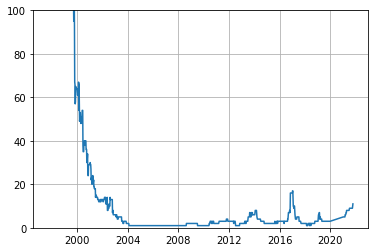

In [30]:
import glob

# rank = pd.concat([pd.read_csv("Player_ranking/atp_rankings_90s.csv"), pd.read_csv("Player_ranking/atp_rankings_00s.csv"), pd.read_csv("Player_ranking/atp_rankings_10s.csv"), pd.read_csv("Player_ranking/atp_rankings_20s.csv"), pd.read_csv("Player_ranking/atp_rankings_current.csv")])

# display(rank.head())
# display(rank.shape)

# fed_rank = rank[rank["player"] == 103819]

# display(fed_rank.head())
# display(fed_rank.shape)

# fed_rank.to_csv("fed_ranking.csv")   # saving the cleaned up table to atp_cat for ease of use

fed_rank = pd.read_csv("fed_ranking.csv")

fed_rank["date"] = pd.to_datetime(fed_rank["ranking_date"], format='%Y%m%d')
fed_rank = fed_rank[["rank", "date"]]

plt.plot(fed_rank["date"], fed_rank["rank"])
plt.ylim(0, 100)
plt.grid("on")

### Federer win streaks

We need to add a column representing the win streak coming into the current match.

In [33]:
result = fed.fed_won.astype(int)

consecutive = result.groupby((result != result.shift()).cumsum()).cumcount()    # identifying the streaks by comparing to a shifted column

wins = pd.DataFrame({"win" : result, "consecutive" : consecutive})

m = wins.win == 1   # masking out lose streaks
wins.consecutive = wins.consecutive.where(m, 0)

fed["consecutive"] = wins.consecutive

fed.to_csv("fed.csv")

fed.tail(10)

,tourney_name,surface,tourney_level,tourney_date,fed_age,opp_name,opp_hand,opp_ht,opp_ioc,opp_age,score,best_of,round,minutes,fed_rank,fed_rank_points,opp_rank,opp_rank_points,fed_won,consecutive
85305,Roland Garros,Clay,G,20210531,39.811088,Denis Istomin,R,188.0,UZB,34.729637,6-2 6-4 6-3,5,R128,93.0,8.0,5605.0,204.0,343.0,1,0
85361,Roland Garros,Clay,G,20210531,39.811088,Marin Cilic,R,198.0,CRO,32.670773,6-2 2-6 7-6(4) 6-2,5,R64,155.0,8.0,5605.0,47.0,1388.0,1,1
85389,Roland Garros,Clay,G,20210531,39.811088,Dominik Koepfer,L,180.0,GER,27.088296,7-6(5) 6-7(3) 7-6(4) 7-5,5,R32,215.0,8.0,5605.0,59.0,1134.0,1,2
85451,Halle,Grass,A,20210614,39.849418,Felix Auger Aliassime,R,193.0,CAN,20.848734,4-6 6-3 6-2,3,R16,104.0,8.0,5065.0,21.0,2423.0,0,0
85461,Halle,Grass,A,20210614,39.849418,Ilya Ivashka,R,193.0,BLR,27.301848,7-6(4) 7-5,3,R32,94.0,8.0,5065.0,90.0,855.0,1,0
85607,Wimbledon,Grass,G,20210628,39.887748,Adrian Mannarino,L,183.0,FRA,32.996578,6-4 6-7(3) 3-6 6-2 0-0 RET,5,R128,164.0,8.0,4815.0,41.0,1571.0,1,1
85646,Wimbledon,Grass,G,20210628,39.887748,Richard Gasquet,R,185.0,FRA,35.028063,7-6(1) 6-1 6-4,5,R64,111.0,8.0,4815.0,56.0,1148.0,1,2
85666,Wimbledon,Grass,G,20210628,39.887748,Cameron Norrie,L,188.0,GBR,25.848049,6-4 6-4 5-7 6-4,5,R32,155.0,8.0,4815.0,34.0,1770.0,1,3
85676,Wimbledon,Grass,G,20210628,39.887748,Lorenzo Sonego,R,191.0,ITA,26.132786,7-5 6-4 6-2,5,R16,131.0,8.0,4815.0,27.0,2038.0,1,4
85681,Wimbledon,Grass,G,20210628,39.887748,Hubert Hurkacz,R,196.0,POL,24.375086,6-3 7-6(4) 6-0,5,QF,109.0,8.0,4815.0,18.0,2533.0,0,0
